In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
#!py -m pip install stldecompose
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

pio.renderers.default='iframe'

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
# init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
import yfinance as yf  # for downloading stock data
from pandas.api.types import is_numeric_dtype
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

dataframe = yf.download("INTC", period="max")
#print ("shape = ", df.shape)
#print(df.head())

# we don't need Adj Close column
dataframe = dataframe.drop(columns=['Adj Close'])

# eliminate data before 2015
dataframe['Date'] = pd.to_datetime(dataframe.index)
dataframe = dataframe[(dataframe['Date'].dt.year >= 2015)].copy()
dataframe = dataframe.set_index('Date')

# In addition to the index column called 'Date', keep a new column called Date for future use
dataframe['Date'] = pd.to_datetime(dataframe.index)

print ("shape = ", dataframe.shape)
print(dataframe.head())

[*********************100%%**********************]  1 of 1 completed

shape =  (2412, 6)
                 Open       High        Low      Close    Volume       Date
Date                                                                       
2015-01-02  36.669998  37.160000  36.110001  36.360001  23605600 2015-01-02
2015-01-05  36.200001  36.450001  35.939999  35.950001  32785000 2015-01-05
2015-01-06  36.080002  36.230000  35.259998  35.279999  30847600 2015-01-06
2015-01-07  35.639999  36.070000  35.270000  36.020000  27725200 2015-01-07
2015-01-08  36.369999  37.000000  36.259998  36.689999  31765400 2015-01-08


In [3]:

dataframe['Date'] = pd.to_datetime(dataframe['Date'], dayfirst=True)

if (dataframe['Date'].dt.tz is None):
    print ("Warning! Encountered Date/Time column without localization. Forcing it to 'Asia/Singapore' - ") 
    #dataframe['Date'] = dataframe['Date'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent="shift_forward")
    dataframe['Date'] = dataframe['Date'].dt.tz_localize('Asia/Singapore', ambiguous='NaT', nonexistent="shift_forward")
    dataframe['Date'] = dataframe['Date'].dt.tz_convert(None)

dataframe.index = pd.to_datetime(dataframe['Date'], dayfirst=True)
dataframe.sort_index(inplace=True)



Warning! Encountered Date/Time column without localization. Forcing it to 'Asia/Singapore' - 


In [4]:
dataframe.isna().sum()
dataframe.dropna(inplace=True)

In [5]:
# since prophet is a uni-variate algo, we will drop all columns except Opening Price

dataframe = dataframe.drop(columns=['High', 'Low', 'Close', 'Volume'])

In [6]:
dataframe = dataframe[['Date','Open']]

In [7]:
#Prophet requires columns to be called 'ds' and 'y'
dataframe.columns = ['ds', 'y']


In [8]:
dataframe

,ds,y
Date,,
2015-01-01 16:00:00,2015-01-01 16:00:00,36.669998
2015-01-04 16:00:00,2015-01-04 16:00:00,36.200001
2015-01-05 16:00:00,2015-01-05 16:00:00,36.080002
2015-01-06 16:00:00,2015-01-06 16:00:00,35.639999
2015-01-07 16:00:00,2015-01-07 16:00:00,36.369999
...,...,...
2024-07-28 16:00:00,2024-07-28 16:00:00,31.420000
2024-07-29 16:00:00,2024-07-29 16:00:00,30.850000
2024-07-30 16:00:00,2024-07-30 16:00:00,30.540001


In [9]:
train_df, test_df=dataframe[dataframe.index < '2022-01-01'], dataframe[dataframe.index >= '2022-01-01']
print('Train:\t', train_df.shape)
print('Test:\t', test_df.shape)

Train:	 (1763, 2)
Test:	 (649, 2)


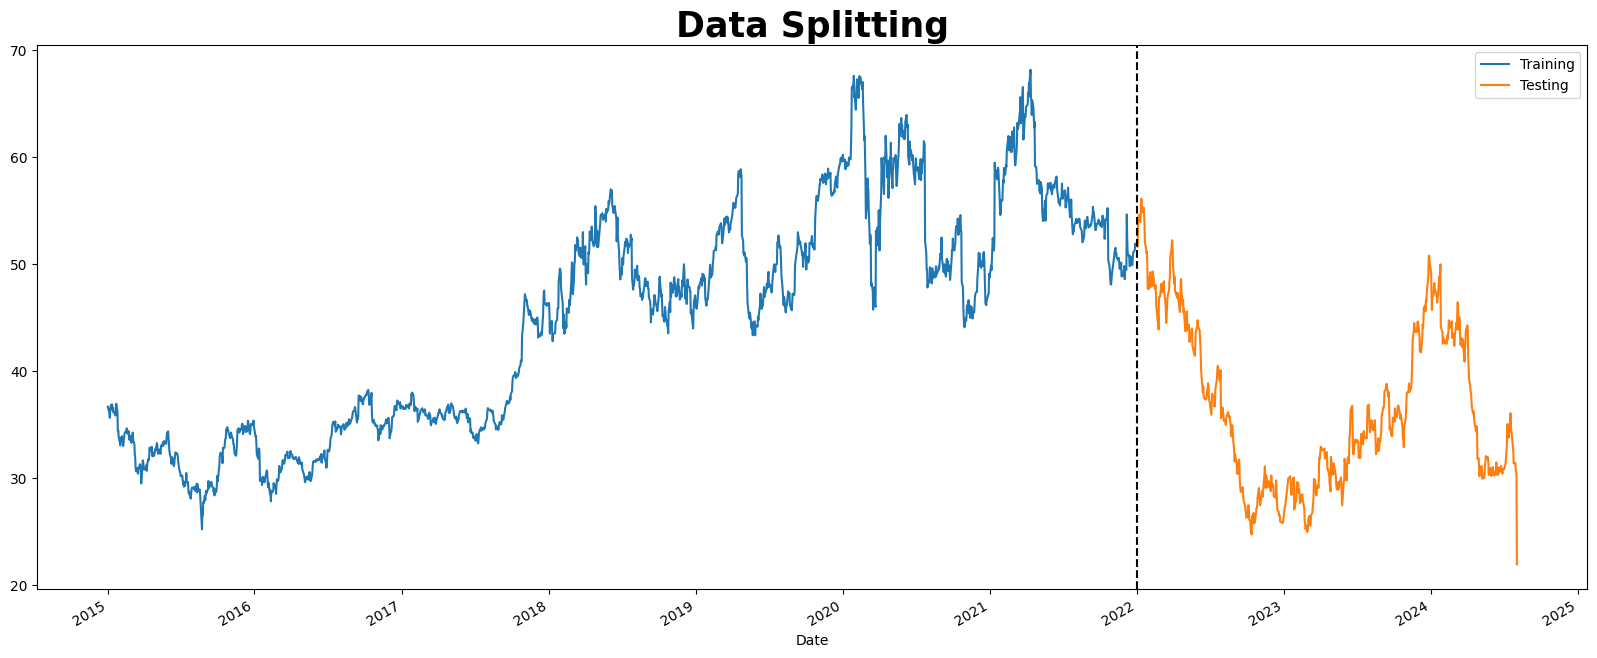

In [10]:
plt.figure(figsize=(20,8))
train_df['y'].plot(label='Training')
test_df['y'].plot(label='Testing')
plt.axvline('2022-01-01', color='black', ls='--')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

In [11]:
from prophet import Prophet

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(train_df)


12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
test_df[['ds']]

,ds
Date,
2022-01-02 16:00:00,2022-01-02 16:00:00
2022-01-03 16:00:00,2022-01-03 16:00:00
2022-01-04 16:00:00,2022-01-04 16:00:00
2022-01-05 16:00:00,2022-01-05 16:00:00
2022-01-06 16:00:00,2022-01-06 16:00:00
...,...
2024-07-28 16:00:00,2024-07-28 16:00:00
2024-07-29 16:00:00,2024-07-29 16:00:00
2024-07-30 16:00:00,2024-07-30 16:00:00


#Plot the model's components
prophet_model.plot_components(dataframe)
plt.show()

In [13]:
print (prophet_model.seasonalities)

OrderedDict({'yearly': {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}, 'weekly': {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}})


In [14]:
#make a prediction within the sample time range
prophet_predict_df = prophet_model.predict(test_df[['ds']])


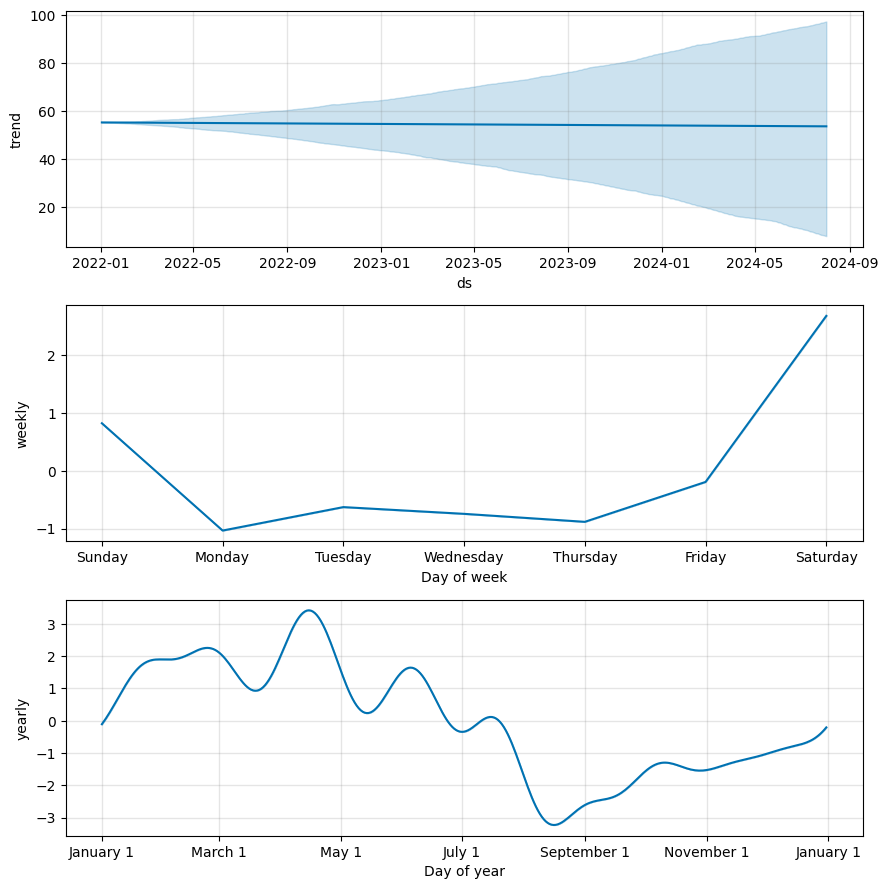

In [15]:
#Plot the model's components
prophet_model.plot_components(prophet_predict_df)
plt.show()

In [16]:
# check a prediction by parsing input Date from a json
import json
import numpy
from io import StringIO
#json_str = "{\"data\": [ [\"2024-02-02 02:30:00\"], [\"2024-03-05 17:45:00\"] ]}"
#json_list=json.loads(json_str)["data"]
#print (json_list)

#Date_strlist = numpy.array(json_list)
#Date_list = [Date.strptime(date[0], '%Y-%m-%d %H:%M:%S') for date in Date_strlist]
#df = pd.DataFrame (Date_list, columns=['ds'])

json_str = "{\"data\": [ \"2024-02-02 02:30:00\", \"2025-03-05 17:45:00\" ]}"
df = pd.read_json(StringIO(json_str))
#print ("***", df)
df.columns = ['ds']
#print ("***", df)
df['ds'] = pd.to_datetime(df['ds'])
df.index = pd.to_datetime(df['ds'])


pred_df = prophet_model.predict(df)
print ("Preds = ", pred_df['yhat'].values, "with Confidence = ", prophet_model.interval_width * 100, "%")

Preds =  [55.91931062 54.25294409] with Confidence =  95.0 %


In [17]:
prophet_predict_df.shape

(649, 19)

In [18]:
prophet_predict_df.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

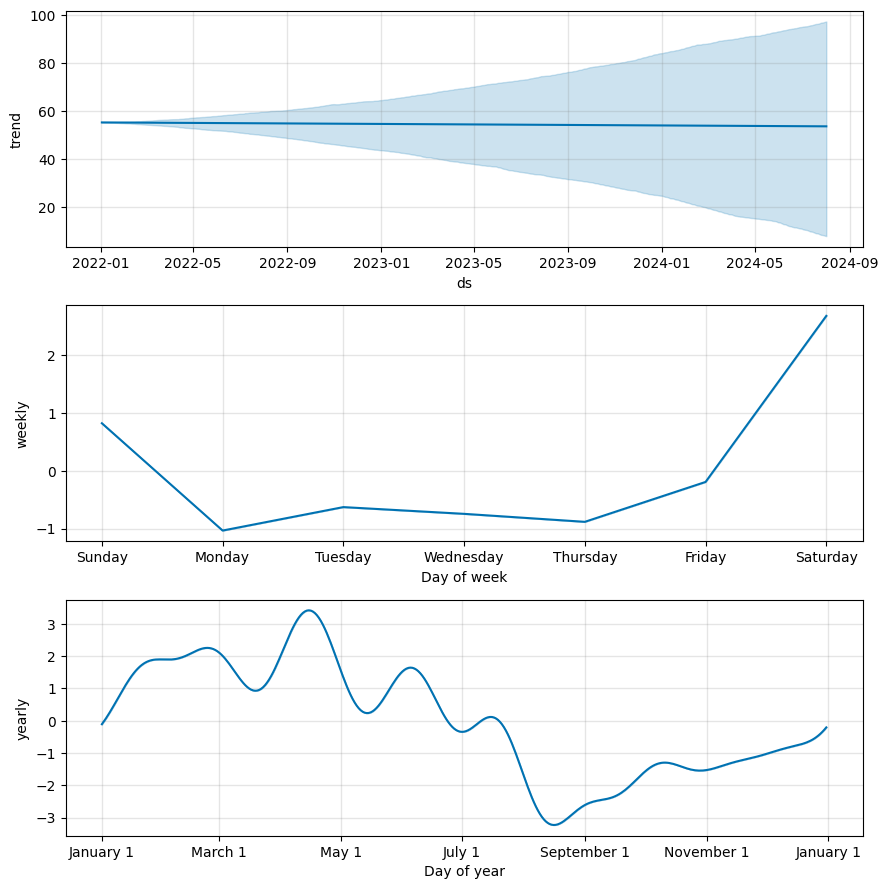

In [19]:
#Plot the model's components
prophet_model.plot_components(prophet_predict_df)
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error
y_true = test_df['y'].values
y_pred = prophet_predict_df['yhat'].values

print (y_true)

print (y_pred)

mean_absolute_error = mean_absolute_error(y_true, y_pred)
print ("mean_absolute_error: %.4f" % mean_absolute_error)

[51.65000153 53.56999969 54.18999863 54.61000061 54.18999863 53.97000122
 55.5        56.13999939 56.         54.84999847 55.31000137 54.63000107
 53.86000061 52.08000183 51.47999954 51.00999832 51.13000107 49.97999954
 47.70999908 47.68000031 48.77999878 48.25       49.25       47.86000061
 48.13000107 47.97999954 49.33000183 49.18000031 48.95000076 47.91999817
 47.70000076 48.06000137 47.86000061 46.18999863 44.68999863 45.16999817
 43.90000153 46.93000031 47.         47.54000092 47.52000046 48.18000031
 47.36999893 48.00999832 47.68999863 48.40999985 47.29000092 47.15000153
 45.90000153 44.5        45.29999924 46.31999969 46.81999969 47.45999908
 47.5        48.45999908 48.65999985 50.68999863 51.36000061 52.
 52.25       51.20000076 49.83000183 48.16999817 48.83000183 47.43999863
 47.43000031 47.27999878 46.90000153 47.31999969 46.75       46.75
 45.52999878 46.59999847 48.36000061 48.61999893 47.45000076 46.20999908
 46.68999863 45.47999954 45.79000092 44.99000168 43.72000122 44.7

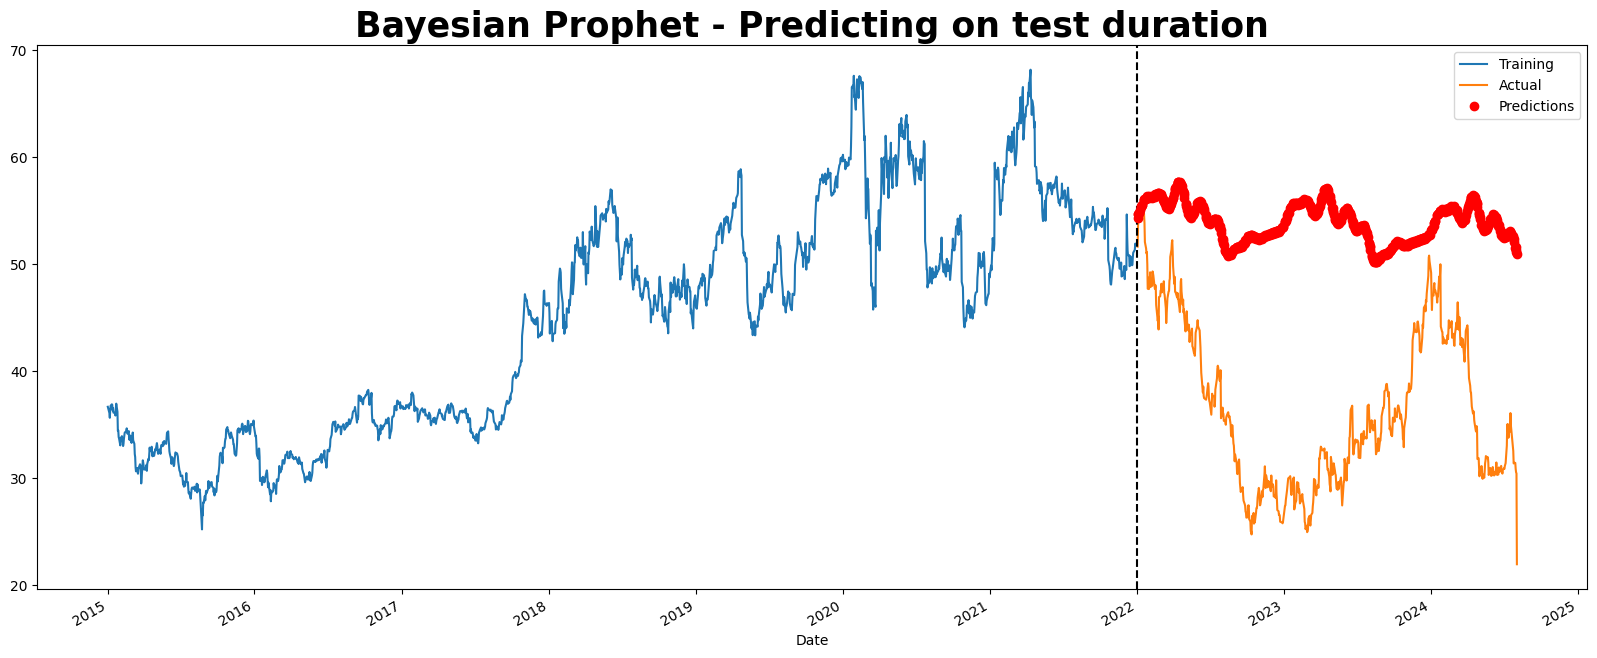

In [21]:
plt.close()
plt.figure(figsize=(20,8))
train_df['y'].plot(label='Training')
test_df['y'].plot(label='Actual')
plt.axvline('2022-01-01', color='black', ls='--')
plt.plot(prophet_predict_df['ds'].values, prophet_predict_df['yhat'].values, 'ro', label='Predictions')
plt.title('Bayesian Prophet - Predicting on test duration', weight='bold', fontsize=25)
plt.legend()

In [22]:
from sklearn.metrics import r2_score

score = r2_score(y_true, y_pred)
print ("coeff of determination score: %.4f" % score)

coeff of determination score: -5.2423


In [23]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
print ("coeff of determination score: %.4f" % r_value**2)

coeff of determination score: 0.1082


In [24]:
# now let's make predictions in the future 

#train with the full available data
prophet_model = Prophet()
prophet_model.fit(dataframe)

12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing


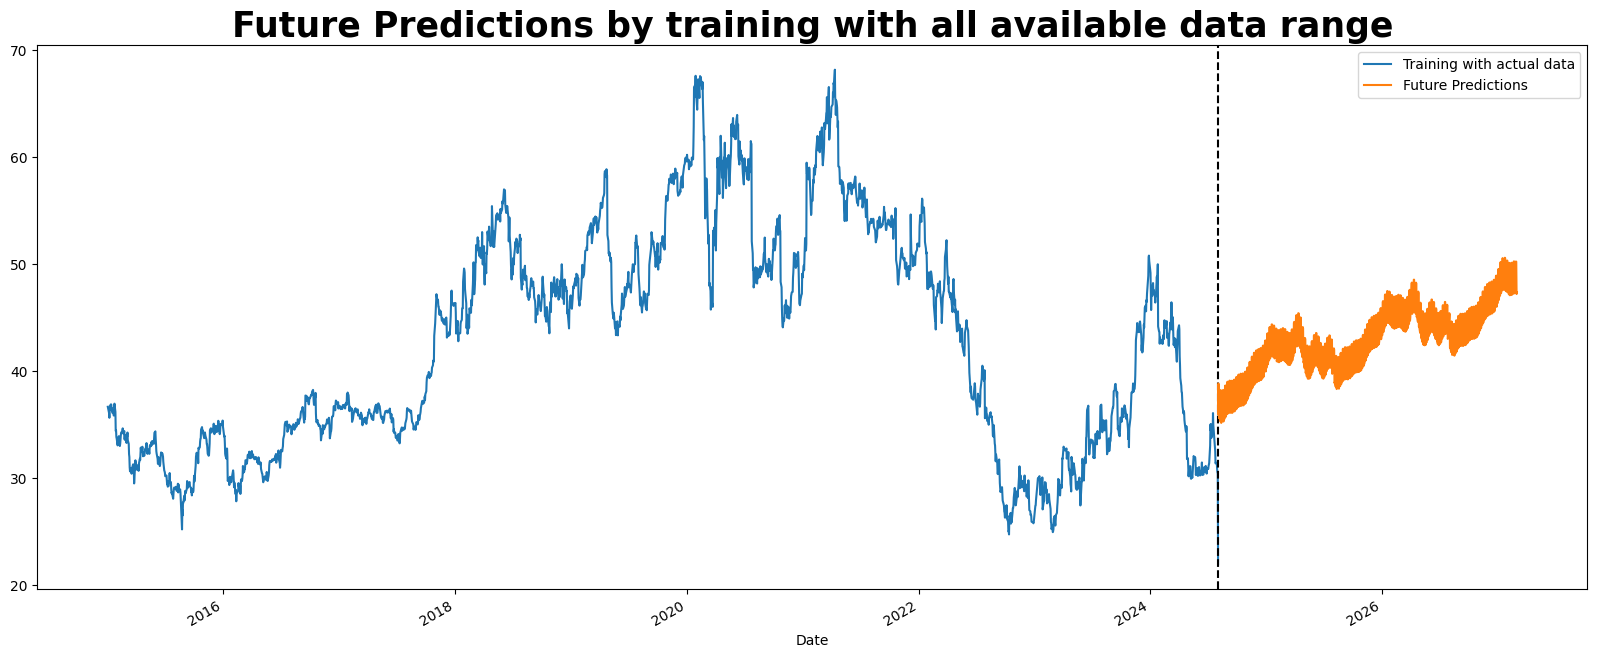

In [25]:
#make a prediction in the future

future = 0
future = test_df['ds'].values.copy()
len = future.size
timedelta =future[len-1]-future[0];

for index, Date in enumerate(future):
    future[index] += timedelta;

future_df = test_df.copy(deep=True);

future_df['ds'] = future.tolist();

future_df['ds'] = pd.to_datetime(future_df['ds'], dayfirst=True)
future_df.sort_index(inplace=True)

prophet_predict_df = prophet_model.predict(future_df[['ds']])

plt.close()
plt.figure(figsize=(20,8))
dataframe['y'].plot(label='Training with actual data')
plt.axvline(dataframe['ds'].values[dataframe.shape[0]-1], color='black', ls='--')
plt.plot(future_df['ds'].values, prophet_predict_df['yhat'].values, label='Future Predictions')
plt.title('Future Predictions by training with all available data range', weight='bold', fontsize=25)
plt.legend()
